## Import libraries

In [1]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

import sklearn
# evaluate RFE for regression
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from xgboost import plot_importance



## Define reusable functions

#### Function for reading data from model dataset

In [2]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    return df_data

## Read pre-processed multi-variable dataset

#### Set python variables

In [3]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data_v3.csv"

#### Read dataset into pandas dataframe

In [4]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

In [5]:
df_model_data

,year,month,date,temp_mean,temp_min,temp_max,temp_avg_daily_min,temp_avg_daily_max,demand_mean,demand_max,demand_avg_daily_max,total_consumption,pv_capacity,population,gsp
0,2010,1,2010-01-01,20.868008,1.6,41.1,16.380645,25.858065,8941.450389,13765.04,10613.530000,6554083.135,28278.392,7110454,44504.250000
1,2010,2,2010-02-01,20.218907,3.2,35.4,16.146429,24.682143,8855.467677,13377.27,10380.667857,5831325.465,32153.986,7119405,44504.250000
2,2010,3,2010-03-01,19.828286,6.3,34.7,15.496774,24.725806,8698.725127,11991.47,10132.978710,6319623.805,38195.588,7128356,44504.250000
3,2010,4,2010-04-01,17.593856,6.5,29.9,12.780000,23.063333,8452.863411,11436.13,9804.072333,5984627.295,45142.723,7133668,44504.250000
4,2010,5,2010-05-01,15.323485,3.1,28.4,11.187097,19.596774,8897.770510,12386.49,10558.023548,6459781.390,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,2021-08-01,21.104167,16.9,30.7,17.766667,24.966667,7368.353056,9043.62,8410.176667,530521.420,3954209.744,8091356,57391.083333
140,2021,9,2021-09-01,20.999306,14.2,27.5,15.433333,25.300000,7229.393819,9206.19,8469.680000,520516.355,4033918.477,8088503,57391.083333
141,2021,10,2021-10-01,21.084722,14.8,26.9,16.300000,25.466667,7209.823194,8841.21,8575.093333,519107.270,4112353.036,8092743,57391.083333
142,2021,11,2021-11-01,22.118056,15.7,27.3,16.466667,26.566667,7649.492569,9573.70,9336.970000,550763.465,4192992.282,8096983,57391.083333


## Using XGBoost Regressor feature importance

In [6]:
columns_to_drop = ['year', 'month', 'date', 'demand_mean', 'total_consumption', 'demand_avg_daily_max', 'demand_max']

## Split data into Response (y) and Independent (X) variable arrays

In [7]:
y_1 = df_model_data['demand_max']
y_2 = df_model_data['demand_mean']
y_3 = df_model_data['demand_avg_daily_max']

X = df_model_data.drop(columns=columns_to_drop, axis=1, inplace=False)

## Fit XGBoost Regression model and plot feature importance chart

In [8]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_1)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [9]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_1)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [10]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_1)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [11]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

In [12]:
df_result

,gain,cover,weight
temp_mean,0.014070,0.050950,0.288908
population,0.023077,0.125549,0.019728
temp_min,0.036125,0.082083,0.162648
temp_avg_daily_min,0.045684,0.123978,0.113985
temp_avg_daily_max,0.062666,0.134508,0.128891
gsp,0.164186,0.264958,0.003507
temp_max,0.217119,0.087279,0.133713
pv_capacity,0.437074,0.130695,0.148619


<Axes: title={'center': 'Feature importance - demand_max'}>

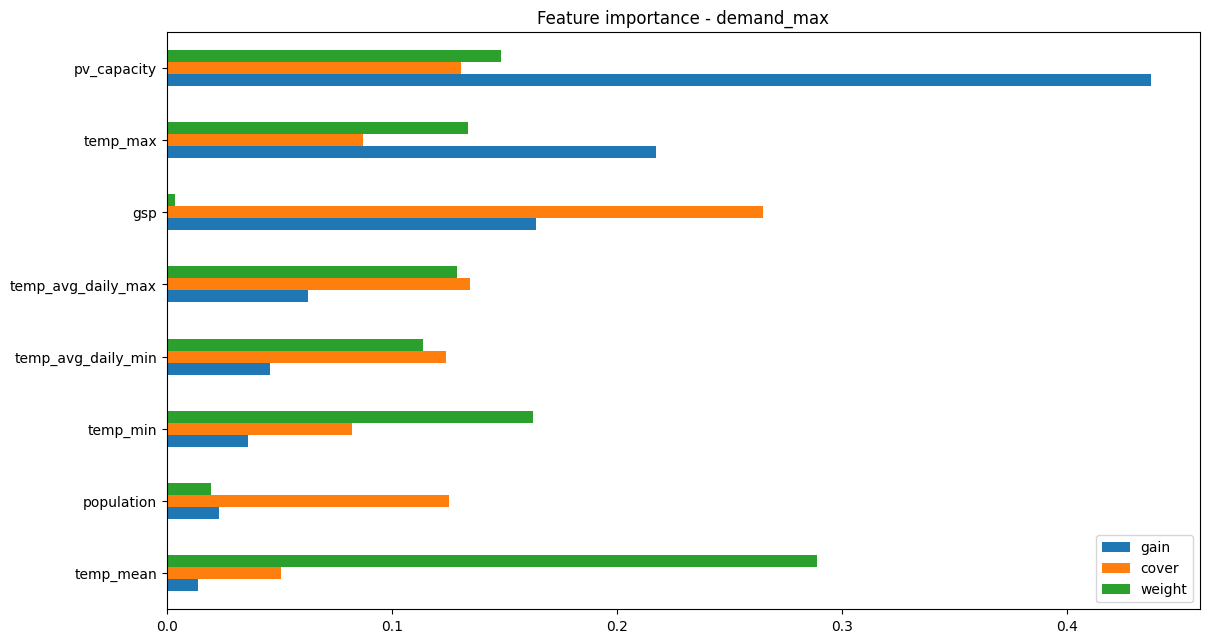

In [13]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_max')

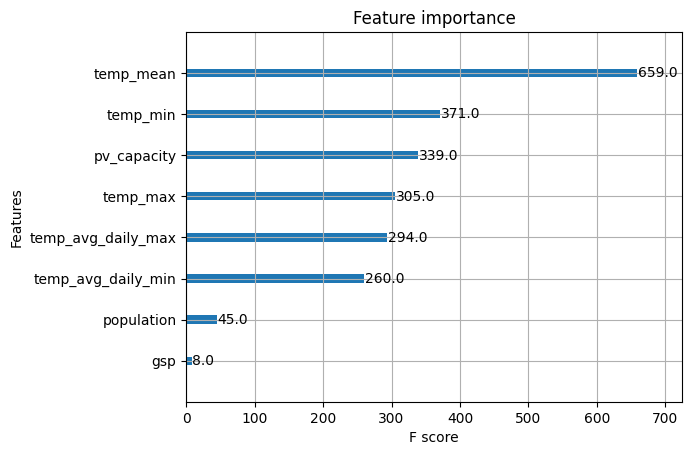

In [14]:
plot_importance(model)
plt.show()

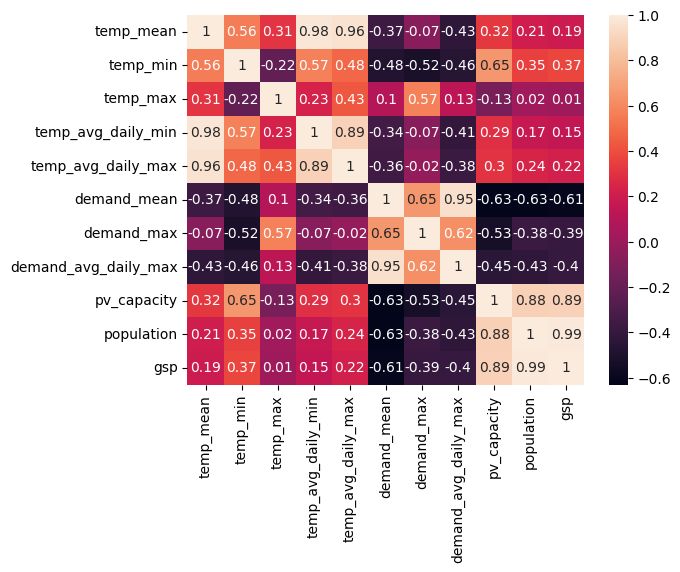

In [17]:
df_model_reduced = df_model_data.drop(['year', 'month', 'date', 'total_consumption'], axis=1, inplace=False)
matrix = df_model_reduced.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [19]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_2)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [20]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_2)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [21]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_2)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [22]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance - demand_mean'}>

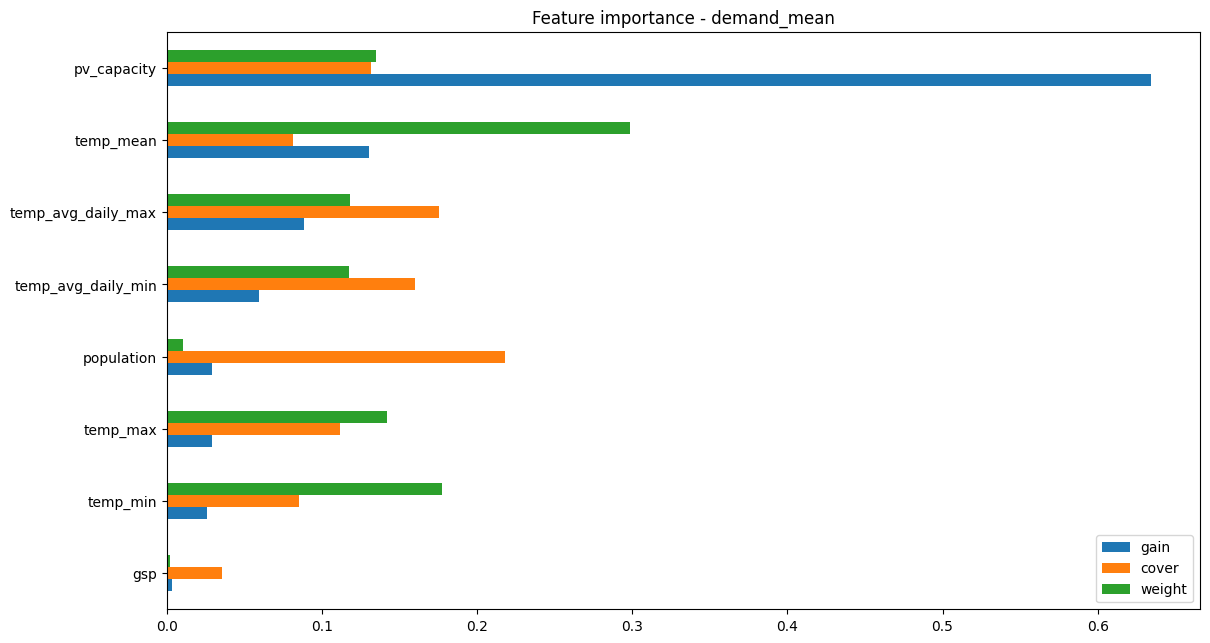

In [23]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_mean')

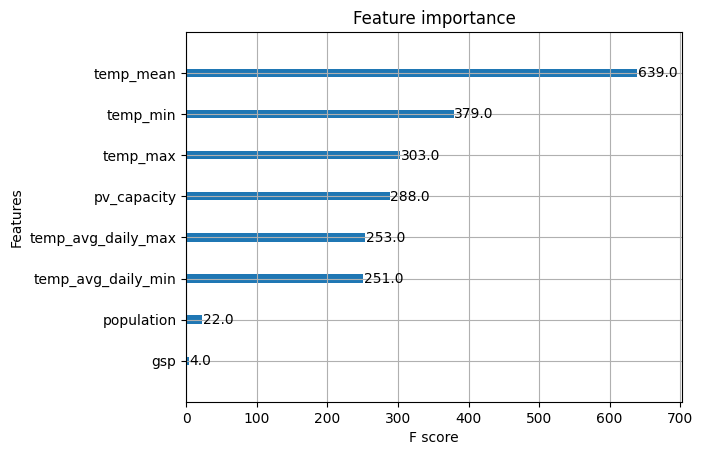

In [24]:
plot_importance(model)
plt.show()

In [25]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_3)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [26]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_3)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [27]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_3)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [28]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance - demand_avg_daily_max'}>

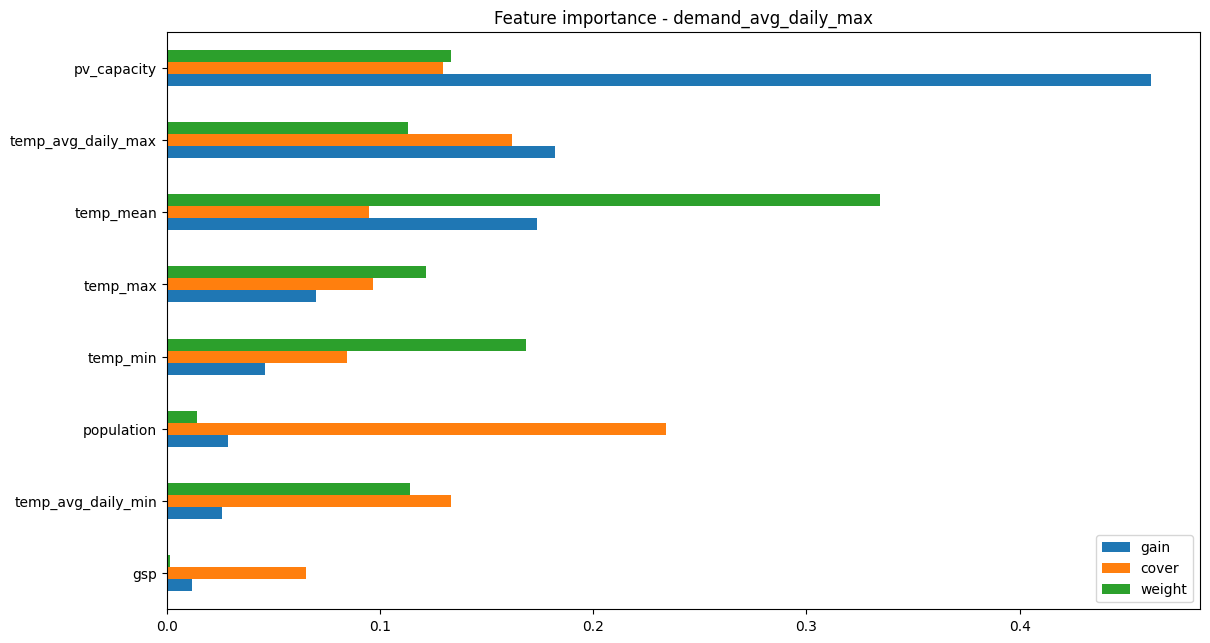

In [29]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_avg_daily_max')

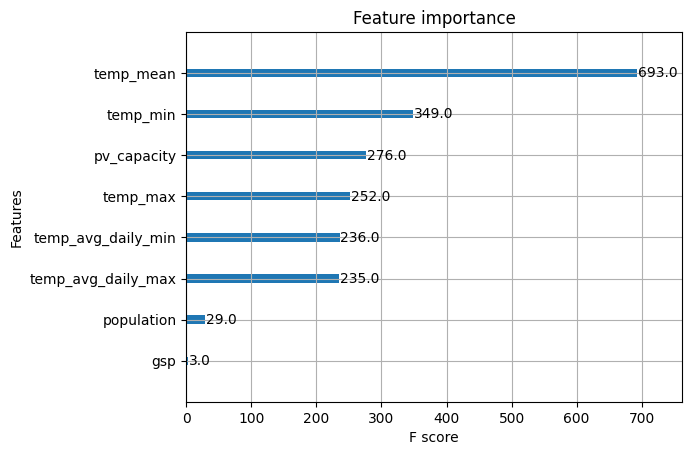

In [30]:
plot_importance(model)
plt.show()

## Using sklearn.feature_selection.RFE

In [31]:
# get a list of models to evaluate
def get_models():
 models = dict()
 # dt
 rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
 # gb
 rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['gb'] = Pipeline(steps=[('s',rfe),('m',model)])
 # rf
 rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
 
 return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores

In [32]:
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y_3, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -254.414 (56.741)


>dt -252.605 (49.953)
>gb -254.020 (51.930)
>rf -260.057 (56.497)


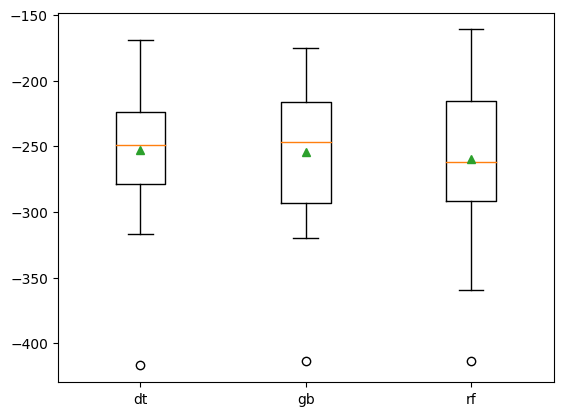

In [35]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 #print(name)
 scores = evaluate_model(model, X, y_3)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [36]:
scores

array([-310.09770609, -211.92398547, -335.16204906, -359.36949211,
       -202.59729022, -287.63294092, -248.77628648, -227.2389796 ,
       -265.96915114, -238.6296205 , -197.0558914 , -263.06633523,
       -413.36803999, -261.23737492, -235.38576575, -292.72709508,
       -184.17248212, -171.06088178, -286.86778078, -289.31272206,
       -161.13551296, -247.474935  , -282.9854064 , -262.7454873 ,
       -207.9790152 , -192.46614231, -304.31961159, -314.19772225,
       -306.9773445 , -239.78805969])

In [37]:
X.columns

Index(['temp_mean', 'temp_min', 'temp_max', 'temp_avg_daily_min',
       'temp_avg_daily_max', 'pv_capacity', 'population', 'gsp'],
      dtype='object')

In [38]:
# report which features were selected by RFE

# define RFE
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
# fit RFE
rfe.fit(X, y_3)
# summarize all features
for i in range(X.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 3.000
Column: 2, Selected False, Rank: 4.000
Column: 3, Selected False, Rank: 2.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 5.000
